In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rdkit-pypi
%tensorflow_version 1.15.3

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.3`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


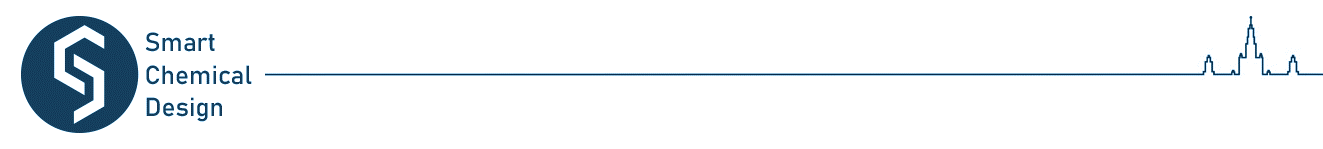

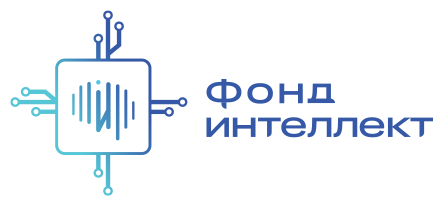

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sys
import subprocess
import os


drive_main_path = "/content/drive/MyDrive/kaka/MolGAN"

sys.path.append(drive_main_path)

from utils.sparse_molecular_dataset import SparseMolecularDataset
from utils.trainer import Trainer
from utils.utils import *
from utils.molecular_metrics import MolecularMetrics
from models.gan import GraphGANModel
from models import encoder_rgcn, decoder_adj, decoder_dot, decoder_rnn

from optimizers.gan import GraphGANOptimizer
from rdkit import RDLogger
from rdkit.Chem import Crippen

RDLogger.DisableLog('rdApp.*')

# Herg activity

### import data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit.Chem import MACCSkeys, AllChem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit import Chem

from sklearn.metrics import f1_score, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Загрузка датасета
mols = Chem.SDMolSupplier("/content/drive/MyDrive/herg.sdf") # На выходе array-like объект с молекулами в виде Mol объектов из rdkit

# Проверим общий размер
print(len(mols))

# Попробуем прочитать желаемое свойство и убедимся, что оно задано для всех молекул
# Используем конструкцию try/except, чтобы выбросить молекулы, для которых могут возникнуть ошибки
activities = []
clean_mols = []
for mol in mols:
    try:
        activities.append(mol.GetProp("herg_activity"))
        clean_mols.append(mol)
    except Exception:
        continue

8154


In [ ]:
X_Hashed = []
y = []

for i in range(len(clean_mols)):
    try:
        arr = np.zeros((1,), dtype=int)
        # print(arr)
        descr = AllChem.GetHashedAtomPairFingerprint(clean_mols[i])
        # print(descr)
        DataStructs.ConvertToNumpyArray(descr, arr)
        # print(arr)
        X_Hashed.append(arr)

        y.append(int(activities[i]))
    except Exception:
        continue

In [ ]:
def mols_to_x(mols):
  X = np.empty(len(mols))
  for i in range(len(mols)):
    arr = np.zeros((1,), dtype=int)
    descr = AllChem.GetHashedAtomPairFingerprint(mols[i])
    DataStructs.ConvertToNumpyArray(descr, arr)
    X.append(arr)
  X = np.stack(X, axis=0)
  return X      

In [ ]:
def mol_to_x(mol):
    arr = np.zeros((1,), dtype=int)
    descr = AllChem.GetHashedAtomPairFingerprint(mol)
    DataStructs.ConvertToNumpyArray(descr, arr)
    return arr  

### Model for herg activity

In [ ]:
X_Hashed = np.stack(X_Hashed, axis=0)
y_np = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_Hashed, y_np, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, matthews_corrcoef
herg_model = RandomForestClassifier(class_weight='balanced_subsample',criterion="entropy",n_estimators=500, warm_start=True)
herg_model.fit(X_train, y_train)

print("accuracy_score =",  accuracy_score(y_test, herg_model.predict(X_test)))
print("precision_score =",  precision_score(y_test, herg_model.predict(X_test)))
print("recall_score =",  recall_score(y_test, herg_model.predict(X_test)))
print("f1_score =",  f1_score(y_test, herg_model.predict(X_test)))
print("matthews_corrcoef =",  matthews_corrcoef(y_test, herg_model.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:766: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  'class_weight presets "balanced" or '


accuracy_score = 0.8994481912936848
precision_score = 0.8901098901098901
recall_score = 0.7232142857142857
f1_score = 0.7980295566502463
matthews_corrcoef = 0.7390347910882991


In [ ]:
herg_model.predict(X_train)

array([1, 0, 0, ..., 1, 0, 0])

In [ ]:
import joblib

filename = os.path.join(drive_main_path, 'herg_model.joblib.pkl')
_ = joblib.dump(herg_model, filename)

# MolGAN

In [ ]:
# Нужно будет поиграться с этими параметрами
batch_dim = 128
la = 1
dropout = 0
n_critic = 5
metric = 'logp,herg'  # список базовых свойств оценки молекулы
n_samples = 5000
z_dim = 8
epochs = 10
save_every = 1
output_dir = os.path.join(drive_main_path, 'output_upgraded') # Директория с натренированной моделью, рекомендуется не перезаписывать ее, а создать отдельную папку
                                                     # для записи Ваших моделей
model_folder = os.path.join(drive_main_path, 'output')

In [ ]:
## попробуем без val и тест
# data.generate(os.path.join(drive_main_path, 'data/gdb9.sdf'), filters=lambda x: x.GetNumAtoms() <= 9, validation=0, test=0)

In [ ]:
# data.save(os.path.join(drive_main_path, 'data/gdb9.sparsedataset'))
data = SparseMolecularDataset()
data.load(os.path.join(drive_main_path, 'data/gdb9.sparsedataset'))
steps = (len(data) // batch_dim)

In [ ]:
# Тут необходимо модифицировать функции оценки под условия задачи
def water_octanol_partition_coefficient_scores(mols, norm=False):
    scores = [MolecularMetrics._avoid_sanitization_error(lambda: Crippen.MolLogP(mol)) if mol is not None else None for mol in mols]
    scores = np.array(list(map(lambda x: -3 if x is None else x, scores)))  # заменяем на -3 если None

    scores = [1 if -0.4 <= x <=5.6 else 0 for x in scores]
    # print(scores)

    return np.array(scores)

# Написать функцию оценки сходства по целевому свойству
def activity_coefficient(mols): # herg activity

    X_mols = [MolecularMetrics._avoid_sanitization_error(lambda: mol_to_x(mol)) if mol is not None else None for mol in mols]
    if len(X_mols) == 0:
       return np.array([])
    else: 
        scores = herg_model.predict(np.array(X_mols))
        return np.array(scores)
    

### Проверим предсказывается ли активность к herg в датасете gdb9


In [ ]:
test_data = activity_coefficient(data.data)

In [ ]:
print(np.unique(test_data), len(test_data))

[0] 133171


Ни одной активной молекулы

## Обучение

In [ ]:
# Вспомогательные функции для тренировки
def train_fetch_dict(i, steps, epoch, epochs, min_epochs, model, optimizer):
    a = [optimizer.train_step_G] if i % n_critic == 0 else [optimizer.train_step_D]
    b = [optimizer.train_step_V] if i % n_critic == 0 and la < 1 else []
    return a + b


def train_feed_dict(i, steps, epoch, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_train_batch(batch_dim)
    embeddings = model.sample_z(batch_dim)

    if la < 1:

        if i % n_critic == 0:
            rewardR = reward(mols)

            n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                               feed_dict={model.training: False, model.embeddings: embeddings})
            n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
            mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

            rewardF = reward(mols)

            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.rewardR: rewardR,
                         model.rewardF: rewardF,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}

        else:
            feed_dict = {model.edges_labels: a,
                         model.nodes_labels: x,
                         model.embeddings: embeddings,
                         model.training: True,
                         model.dropout_rate: dropout,
                         optimizer.la: la if epoch > 0 else 1.0}
    else:
        feed_dict = {model.edges_labels: a,
                     model.nodes_labels: x,
                     model.embeddings: embeddings,
                     model.training: True,
                     model.dropout_rate: dropout,
                     optimizer.la: 1.0}

    return feed_dict

# Вспомогательные функции для оценки

def eval_fetch_dict(i, epochs, min_epochs, model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def eval_feed_dict(i, epochs, min_epochs, model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_validation_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict

# Вспомогательные функции для тестирования
def test_fetch_dict(model, optimizer):
    return {'loss D': optimizer.loss_D, 'loss G': optimizer.loss_G,
            'loss RL': optimizer.loss_RL, 'loss V': optimizer.loss_V,
            'la': optimizer.la}


def test_feed_dict(model, optimizer, batch_dim):
    mols, _, _, a, x, _, _, _, _ = data.next_test_batch()
    embeddings = model.sample_z(a.shape[0])

    rewardR = reward(mols)

    n, e = session.run([model.nodes_gumbel_argmax, model.edges_gumbel_argmax],
                       feed_dict={model.training: False, model.embeddings: embeddings})
    n, e = np.argmax(n, axis=-1), np.argmax(e, axis=-1)
    mols = [data.matrices2mol(n_, e_, strict=True) for n_, e_ in zip(n, e)]

    rewardF = reward(mols)

    feed_dict = {model.edges_labels: a,
                 model.nodes_labels: x,
                 model.embeddings: embeddings,
                 model.rewardR: rewardR,
                 model.rewardF: rewardF,
                 model.training: False}
    return feed_dict


# Функция для расчета ошибки на текущем этапе тренировки, необходимо дополнить ее Вашей функцией для оценки активности
def reward(mols):
    rr = 1.
    for m in ('logp,sas,qed,unique,herg' if metric == 'all' else metric).split(','):

        if m == 'np':
            rr *= MolecularMetrics.natural_product_scores(mols, norm=True)
        # elif m == 'logp':
        #     rr *= MolecularMetrics.water_octanol_partition_coefficient_scores(mols, norm=True)
        elif m == 'logp':
            rr *= water_octanol_partition_coefficient_scores(mols, norm=False)
        elif m == 'sas':
            rr *= MolecularMetrics.synthetic_accessibility_score_scores(mols, norm=True)
        elif m == 'qed':
            rr *= MolecularMetrics.quantitative_estimation_druglikeness_scores(mols, norm=True)
        elif m == 'novelty':
            rr *= MolecularMetrics.novel_scores(mols, data)
        elif m == 'dc':
            rr *= MolecularMetrics.drugcandidate_scores(mols, data)
        elif m == 'unique':
            rr *= MolecularMetrics.unique_scores(mols)
        elif m == 'diversity':
            rr *= MolecularMetrics.diversity_scores(mols, data)
        elif m == 'validity':
            rr *= MolecularMetrics.valid_scores(mols)
            
        elif m == 'herg':
            rr *= activity_coefficient(mols)

        else:
            raise RuntimeError('{} is not defined as a metric'.format(m))

    return rr.reshape(-1, 1)

# вспомогательные функции для расчета ошибок
def _eval_update(i, epochs, min_epochs, model, optimizer, batch_dim, eval_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0


def _test_update(model, optimizer, batch_dim, test_batch):
    mols = samples(data, model, session, model.sample_z(n_samples), sample=True)
    m0, m1 = all_scores(mols, data, norm=True)
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    return m0

In [ ]:
tf.reset_default_graph()
# model
model = GraphGANModel(data.vertexes,
                      data.bond_num_types,
                      data.atom_num_types,
                      z_dim,
                      decoder_units=(128, 256, 512),
                      discriminator_units=((128, 64), 128, (128, 64)),
                      decoder=decoder_adj,
                      discriminator=encoder_rgcn,
                      soft_gumbel_softmax=False,
                      hard_gumbel_softmax=False,
                      batch_discriminator=False)

# optimizer
optimizer = GraphGANOptimizer(model, learning_rate=1e-3, feature_matching=False)

# session
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session.run(tf.global_variables_initializer())

# trainer
trainer = Trainer(model, optimizer, session)

print('Parameters: {}'.format(np.sum([np.prod(e.shape) for e in session.run(tf.trainable_variables())])))
trainer.load(model_folder)

trainer.train(batch_dim=batch_dim,
              epochs=epochs,
              steps=steps,
              train_fetch_dict=train_fetch_dict,
              train_feed_dict=train_feed_dict,
              eval_fetch_dict=eval_fetch_dict,
              eval_feed_dict=eval_feed_dict,
              test_fetch_dict=test_fetch_dict,
              test_feed_dict=test_feed_dict,
              save_every=save_every,
              directory=output_dir,
              _eval_update=_eval_update,
              _test_update=_test_update)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Parameters: 575556
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/kaka/MolGAN/output/model.ckpt
2022-04-16 20:48:27 Model loaded from /content/drive/MyDrive/kaka/MolGAN/output!
2022-04-16 20:48:27 Epochs          0/10 in 0:00:00 (last epoch in 0:00:00), ETA: -:--:-
2022-04-16 20:49:24 Validation --> {'NP score': 0.9501956957181034,
 'QED score': 0.4966631517365126,
 'SA score': 0.32604866216207906,
 'diversity score': 0.5978439499385452,
 'drugcandidate score': 0.3607930139006876,
 'la': 1.0,
 'logP score': 0.339965847808902,
 'loss D': nan,
 'loss G': nan,
 'loss RL': nan,
 'loss V': nan,
 'novel score': 47.36396955173386,
 'unique score': 23.428249224696927,
 'valid score': 70.93999981880188}
2022-04-16 20:49:28 Model saved in /content/drive/MyDrive/kaka/MolGAN/output_upgraded!
 100% (1040/1040) [################################################################################